## Opis problema

Naš zadatak je da iz skupa podataka o pacijentima koji su podvrgnuti **elektrokonverziji** napravimo **klasifikacioni model** koji predviđa da li će procedura biti uspešna. 
U ovoj svesci predstavljeni su različiti modeli dobijeni primenom: drveta odlučivanja, naivnog Bajesa, metoda potpornih vektora i neuronskih mreža.

## Učitavanje podataka

Podaci su dimenzija **147 x 49**. Redovi predstavljaju pacijente indeksirane po broju iz baze, a atributi su karakteristike zdravstvenog stanja pacijenata i karakteristike primenjene elektrokonverzije. 
Ulazni atributi su celobrojnog tipa, a ciljni atribut (uspešnost elektrokonverzije) je istinitosnog tipa. Važno je napomenuti da je skup podataka **nebalansiran**: klasa *True (uspešna elektrokonverzija)* je zastupljena u 130 zapisa, dok je klasa *False (neuspešna elektrokonverzija)* zastupljena u svega 17 zapisa.

In [1]:
import pandas as pd 

df = pd.read_csv(
        'elektroprecisceno.csv',
         index_col=0
     )
df

,godine,stariji,Pol,indikacija:,ukupno,trajanje,frekvenca,Blok,dimenzija,EDD,...,Sotalol,Digoksin,ASA,OAKT,Plavix,Statin,Implantiran,Vreme,"sinhroni,",Elektrokonverzija
Broj,,,,,,,,,,,,,,,,,,,,,
1,78,1,1,1,5,5,0,3,42,56,...,0,0,0,2,0,0,1,2,2,True
2,61,0,1,2,24,1,7,0,42,59,...,0,0,0,2,0,0,0,-1,2,True
3,65,1,1,1,4,4,0,3,47,55,...,0,0,0,2,0,0,1,3,2,True
4,64,0,1,1,288,2,7,0,50,50,...,0,0,0,2,0,0,0,-1,2,True
5,65,1,2,1,48,3,9,0,49,61,...,0,0,0,2,0,1,0,-1,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,61,0,1,2,2,2,0,3,36,54,...,0,0,0,2,0,0,1,2,2,True
647,58,0,1,2,12,2,0,3,45,57,...,0,0,0,3,0,1,1,2,2,True
648,72,1,2,1,20,20,6,0,43,66,...,0,1,0,3,0,0,0,-1,2,True


## Podela podataka na trening i test

Skup podataka delimo na deo za treniranje modela i deo za testiranje dobijenog modela. Podela će se vršiti pre primene svakog od različitih algoritama kako bi se poništile moguće transformacije nad podacima i kako bi bila izabrana odgovarajuća veličina skupa za testiranje. 
Argumenti podele će uvek biti isti za sve algoritme, osim kada je u pitanju veličina test skupa.
Prosleđeni argument *random_state* je postavljen na 0 jer se na taj način dobija uvek isto podeljen skup podataka, što je pogodno za upoređivanje modela. 
Argument *stratify* dobija vrednost ciljane kolone kako bi raspodela podataka u trening i test skupu ostala približno ista kao u početnom skupu, što je posebno važno jer je u pitanju nebalansirani skup. 
Koristi se i *sampler* za dodatno balansiranje. 

In [2]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

tts = train_test_split

def train_test_split(X, y, sampler=None, test=0.35):
    X_train, X_test, y_train, y_test = tts(X, y, random_state=0, stratify=y, test_size=test)
    
    if sampler is not None:
        X_train, y_train = sampler(random_state=0).fit_resample(X_train, y_train)
    
    return X_train, X_test, y_train, y_test

## Kvalitet modela

Mera koja nam daje najviše informacija o kvalitetu modela je **balansirana tačnost** koja predstavlja srednju vrednost odziva za svaku klasu (međutim, ona nije pouzdana ukoliko je odziv neke od klasa jednak nuli). Korišćeni su i matrica konfuzije i izveštaj klasifikacije koji nam pružaju detaljniji uvid u različite osobine modela. Funkcija prijavljuje i loše klasifikovane False instance, ukoliko je u mogućnosti.

In [3]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import numpy as np

_, XXX, _, _ = train_test_split(X, y)

def kvalitet_modela(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print('Balansirana tačnost:', balanced_accuracy_score(y_test,y_pred))
    
    try:
        print('Greške:', XXX.iloc[np.where((y_pred != y_test) & ~y_test)].index.to_numpy())
    except:
        pass

## Stablo odlučivanja

**Stablo odlučivanja** je klasifikator koji u svakom unutrašnjem čvoru sadrži upit za određeni atribut na osnovu kog se pretraga dalje usmerava kroz adekvatne grane, u naredne čvorove. Za razliku od unutrašnjih čvorova, svakom listu je pridružena odgovarajuća klasa. Da bismo klasifikovali neki podatak na osnovu atributa se usmeravamo kroz stablo odgovarajućim granama, sve do nekog lista koji nam govori kojoj klasi podatak pripada.

Za treniranje i kreiranje modela stabla odlučivanja, zbog nebalansiranosti skupa podataka, prosleđen je argument **class_weight** koji dobija vrednost *'balanced'* i koji označava da su težine svake klase obrnuto srazmerne njihovoj zastupljenosti u skupu.

Najbolje stablo dobijeno je sa veličinom test skupa podešenom na 35% veličine početnog skupa.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)

kvalitet_modela(clf, X_test, y_test)

[[ 2  4]
 [ 3 43]]
              precision    recall  f1-score   support

       False       0.40      0.33      0.36         6
        True       0.91      0.93      0.92        46

    accuracy                           0.87        52
   macro avg       0.66      0.63      0.64        52
weighted avg       0.86      0.87      0.86        52

Balansirana tačnost: 0.6340579710144928
Greške: [636  63 312 320]


## ROC kriva modela

Sa ROC krive modela uočavamo kako se stablo ponaša za različite vrednosti granice (*threshold*) verovatnoće. Granica verovatnoće predstavlja verovatnoću koja je potrebna da bi se nešto smatralo pozitivnom klasom (podrazumevano u modelu stabla ta vrednost je 0.5).

Nad ovim modelom uočavamo da ne postoji dovoljno dobra vrednost granice koja bi poboljšala model, i još jednom potvrđujemo da model nije dovoljno dobar.

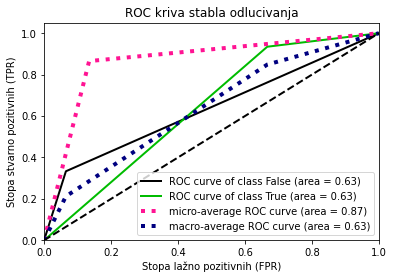

In [6]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc
import scikitplot as skplt

y_probas = clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)

plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa stvarno pozitivnih (TPR)')

plt.title('ROC kriva stabla odlucivanja')
plt.legend(loc="lower right")

plt.show()

## Skraćivanje stabla


Dobijeno stablo je u potpunosti prilagođeno trening podacima i ne pokazuje dovoljno dobre performanse nad test podacima. Zbog toga treba pokušati sa poboljšanjem modela koje se postiže odsecanjem delova stabla.
Za to je korišćena tehnika odsecanja pomoću parametra **ccp_alpha** gde se za veće vrednosti parametra odseca veći broj čvorova.
Za različite vrednosti parametra ispitan je kvalitet dobijenog stabla (*balanced_accuracy_score*). Međutim, **najbolji kvalitet** se dobija za *alpha=0.0*, što znači da se odsecanjem stabla ne dobijaju bolji rezultati.

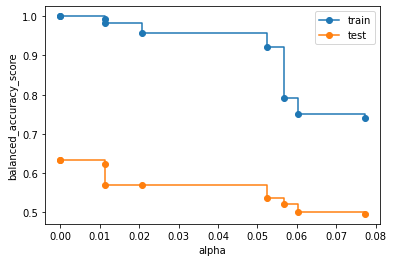

In [7]:
ccp_alphas = clf.cost_complexity_pruning_path(X_train, y_train).ccp_alphas[:-1]

clfs = []
for ccp_alpha in ccp_alphas:
    clf_pruned = DecisionTreeClassifier(random_state = 0, class_weight='balanced', ccp_alpha = ccp_alpha)
    clf_pruned.fit(X_train, y_train)
    clfs.append(clf_pruned)

fig, ax = plt.subplots()

train_scores = [balanced_accuracy_score(y_train,clf_pruned.predict(X_train)) for clf_pruned in clfs]
test_scores = [balanced_accuracy_score(y_test,clf_pruned.predict(X_test)) for clf_pruned in clfs]

ax.set_xlabel("alpha")
ax.set_ylabel("balanced_accuracy_score")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()

plt.show()

Konačno stablo odgovara početnom stablo s obzirom da modifikacije ne doprinose kvalitetu. Balansirana tačnost stabla iznosi $63\%$, pri čemu False klasi odgovara odziv $33\%$ što nije dovoljno dobro.
Konačno stablo prikazano je na slici ispod:

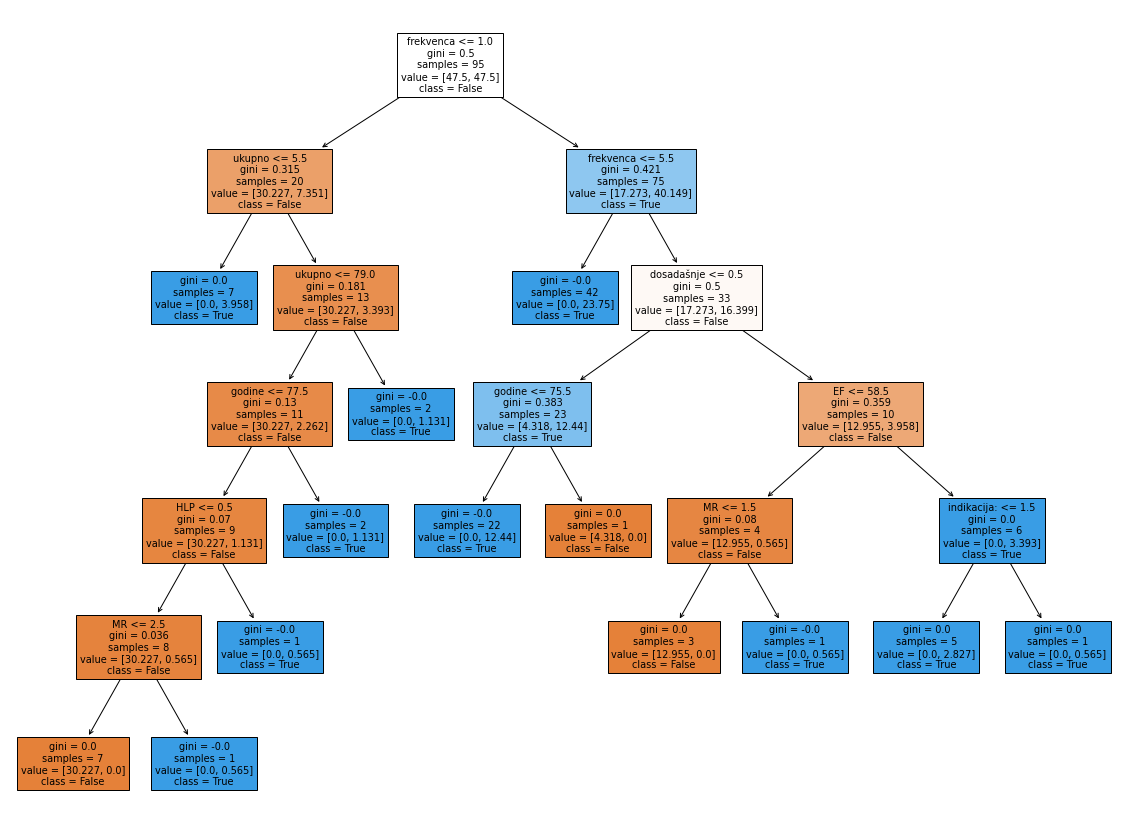

In [8]:
import sklearn.tree as tree

fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(clf, 
                   feature_names=X_train.columns,  
                   class_names=['False','True'],
                   filled=True)

## Ispitivanje povezanosti i značaj atributa $\tiny \text{(dobijene vrednosti biće korišćene kroz kasnije metode )}$

Funkcija *permutation_importance* izračunava značaj atributa za klasifikator nad određenim skupom podataka. 
Značaj se izračunava kao smanjenje nečistoće čvora otežano verovatnoćom dosezanja tog čvora. Što je veća vrednost koja se dobije, to je atribut značajniji.

Dobijeni rezultati biće korišćeni za dobijanje Bajesove mreže pomoću strategije forsiranja određenih grana.

In [9]:
from sklearn.inspection import permutation_importance

importances = sorted(zip(clf.feature_importances_, X.columns), reverse=True)
for importance, column in importances:
    if importance >= 1e-06:
        print(f'{column} : {importance:.6f}')

frekvenca : 0.396828
godine : 0.177675
ukupno : 0.160366
EF : 0.104846
dosadašnje : 0.091570
MR : 0.046186
HLP : 0.022529


Dendrogram i toplotna mapa(heatmap) predstavljaju **korelacije između atributa**.

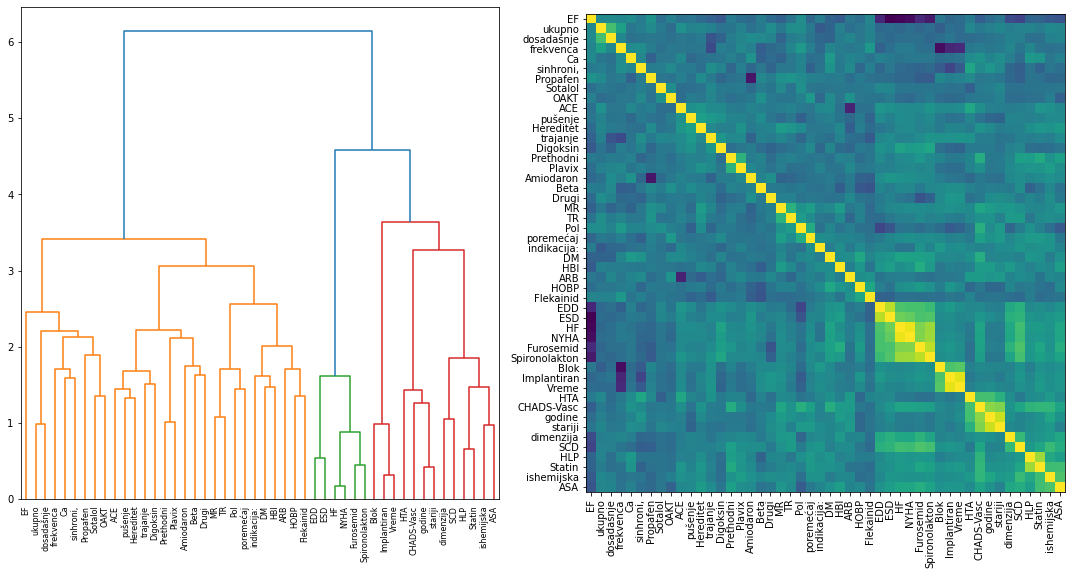

In [10]:
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=X.columns.tolist(), ax=ax1)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

## Primena šume za klasifikaciju

**Slučajna šuma** odgovara različitim drvetima odlučivanja na različitim poduzorcima skupa podataka i ona koristi 
usrednjavanje kako bi poboljšala tačnost predviđanja i kontrolisala preprilagođavanje. Veličina poduzoraka se kontroliše parametrom *max_samples*, ali samo ukoliko je parametar *bootstrap* postavljen na True (ukoliko je *bootstrap* postavljen na False ceo skup se koristi za izgradnju svakog drveta).

Kao i kod drveta odlučivanja, parametar *random_state* je fiksiran i težine klasa su balansirane.
Parametar *n_estimators* predstavlja broj stabala koji želimo da se kreira i na osnovu kojih se procenjuje konačan rezultat (uzima se srednja vrednost za svaku procenu). 
Ispitano je više vrednosti za *n_estimators* i *max_samples* i među njima najbolju balansiranu tačnost daju vrednosti u navedenom modelu.

In [11]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0,
                             bootstrap=True, 
                             n_estimators=2,
                             max_samples=50,
                             class_weight='balanced')
clf.fit(X_train, y_train)
kvalitet_modela(clf, X_test, y_test)

[[ 4  2]
 [12 34]]
              precision    recall  f1-score   support

       False       0.25      0.67      0.36         6
        True       0.94      0.74      0.83        46

    accuracy                           0.73        52
   macro avg       0.60      0.70      0.60        52
weighted avg       0.86      0.73      0.78        52

Balansirana tačnost: 0.7028985507246377
Greške: [636 320]


## Naivni Bajes

Klasifikator **Naivni Bajes** procenjuje uslovnu verovatnoću klase sa pretpostavkom da su atributi međusobno nezavisni. Korelisani atributi mogu narušiti performanse naivnog Bajesovog klasifikatora jer narušavaju pretpostavku o nezavisnosti. Na toplotnoj mapi smo videli da postoje korelacije između određenih atributa, međutim njih nema mnogo, pa ima smisla da ipak pokušamo sa upotrebom ovog klasifikatora.

Korišćena su dva drugačija klasifikatora, **GaussianNB** i **ComplementNB**. GaussianNB pretpostavlja da je raspodela atributa normalna. Zbog toga ćemo pre primene ovog klasifikatora podatke standardizovati.
ComplementNB je dopuna MultionimalNB koji je posebno prilagođen nebalansiranim podacima. ComplementNB ne obrađuje negativne vrednosti atributa, pa je dodatno potrebno podatke skalirati tako da se svi nalaze u nekom pozitivnom opsegu (ovde je to $[0,1)$).

Dobijen model GaussianNB klasifikatora za veličinu test skupa $35\%$ sve podatke svrstava u False klasu. Međutim, Bajesova mreža ne zahteva veliki trening skup kako bi pokazala dobre performanse, pa promenom veličine na $70%$ se dobijaju nešto bolji rezultati, jer više nije u pitanju naivni klasifikator. Međutim, rezultati su i dalje nedovoljno dobri jer balansirana tačnost iznosi samo $48\%$ jer je odziv za obe klase približno $50\%$.

Sa druge strane, model ComplementNB klasifikatora sa RandomOverSampler pokazuje dosta bolje osobine jer balansirana tačnost sada iznosi $73\%$. Model ima vrlo slične performanse kao stablo odlučivanja, ali pogađa jednu dodatnu neuspešnu elektrokonverziju.

In [12]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test=0.7)

scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train,y_train)

kvalitet_modela(gnb, X_test, y_test)

[[ 5  7]
 [41 50]]
              precision    recall  f1-score   support

       False       0.11      0.42      0.17        12
        True       0.88      0.55      0.68        91

    accuracy                           0.53       103
   macro avg       0.49      0.48      0.42       103
weighted avg       0.79      0.53      0.62       103

Balansirana tačnost: 0.4830586080586081


In [14]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, RandomOverSampler)

scaler = MinMaxScaler()  
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

In [15]:
from sklearn.naive_bayes import ComplementNB

cnb = ComplementNB()
cnb.fit(X_train,y_train)
kvalitet_modela(cnb, X_test, y_test)

[[ 3  3]
 [ 2 44]]
              precision    recall  f1-score   support

       False       0.60      0.50      0.55         6
        True       0.94      0.96      0.95        46

    accuracy                           0.90        52
   macro avg       0.77      0.73      0.75        52
weighted avg       0.90      0.90      0.90        52

Balansirana tačnost: 0.7282608695652174
Greške: [  6  63 320]


## Ansambl metoda

Kako su se dosad slučajna šuma i komplementarni naivni Bajes prikazali kao relativno uspešni, a pritom prave samo jednu zajedničku grešku, ima smisla napraviti **ansambl** koji spaja ova dva klasifikatora. Za funkciju odlučivanja može se uzeti pomnožena funkcija odlučivanja ova dva klasifikatora – pacijentu se dodeljuje klasa True samo ako oba člana ansambla tako misle. Ovo je po svim parametrima najbolji rezultat.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

class MojAnsambl:
    def predict(X_test):
        return clf.predict(X_test) * cnb.predict(scaler.transform(X_test))

kvalitet_modela(MojAnsambl, X_test, y_test)

[[ 5  1]
 [12 34]]
              precision    recall  f1-score   support

       False       0.29      0.83      0.43         6
        True       0.97      0.74      0.84        46

    accuracy                           0.75        52
   macro avg       0.63      0.79      0.64        52
weighted avg       0.89      0.75      0.79        52

Balansirana tačnost: 0.786231884057971
Greške: [320]


## Neuronska mreža

**Neuronska mreža** predstavlja simulaciju biološkog nervnog sistema. Naime, ljudski mozak uči promenama jačina sinaptičkih veza između neurona nakon ponovljene simulacije istim impulsima.
**Veštačka neuronska mreža** se sastoji od skupa čvorova koji simuliraju neurone i direktnih veza koje simuliraju sinaptičke veze. Promene težina direktnih veza odgovaraju promenama jačina sinaptičkih veza, a ulazni podaci odgovaraju impulsima.
Najjednostavniji model neuronske mreže je **perceptron**. Granica odlučivanja kod perceptrona je linearna hiperravan koja razdvaja podatke na dve klase. Iz toga razloga, perceptron nije odgovarajući za primenu kod ovog skupa podataka jer smo PCA analizom uvideli da podaci nisu linearno razdvojivi.
Zbog toga nam je potrebna **višeslojna neuronska mreža**. Višeslojne neuronske mreže modeluju kompleksnije odnose između ulaznih i izlaznih promenljivih.U sklearn-u klasa **MLPClassifier** implementira algoritam višeslojnih neuronskih mreža. Takođe, potrebno je skalirati podatke pre treniranja modela.

## Određivanje parametara metoda

GridSearchCV je funkcija koja implementira iscrpnu pretragu nad specifikovanim vrednostima parametara klasifikatora. Parametri se optimizuju unakrsnom validacijom nad mrežom parametara.
Za funkciju ocenjivanja modela korišćene su balansirana tačnost i površina ispod roc krive sa akcentom na balansiranoj tačnosti. 

Parametri potrebni za višeslojnu neuronsku mrežu: <br>
**hidden_layer_sizes** - broj čvorova u skrivenim slojevima <br>
**activation** - određuje aktivacionu funkciju za skriveni sloj <br>
**solver** - rešavač za optimizaciju težina <br>
**alpha** - penalizuje prevelike težine i na taj način pomaže izbegavanju preprilagođavanja <br>
**learning_rate** - način na koji se menja stopa učenja kroz iteracije algoritma <br>
**learning_rate_init** - početna vrednost stope/brzine učenja <br>
**power_t** - parametar za slučaj da je stopa učenja inverzno skaliranje <br>

## Kreiranje i primena neuronske mreže

Neuronska mreža se kreira sa parametrima dobijenim funkcijom GridSearchCV, kao i uz RandomOverSampler. 
Dobijeni model pokazuje manju balansiranu tačnost nego dobijenu unakrsnom validacijom nad mrežom parametara. Pretpostavljamo da se za drugačiju podelu na test i trening podatke dobiju znatno drugačiji rezultati. 
Balansirana tačnost iznosi $54\%$, pri čemu je odziv za *False* klasu jednak $50\%$, a za *True* klasu $63\%$.

In [17]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, RandomOverSampler)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(100,70,),    
                    activation='relu',
                    solver='sgd',
                    alpha=0.1,
                    learning_rate='invscaling',
                    learning_rate_init=0.001,
                    power_t=0.7,
                    max_iter=1000,
                    random_state=1)

clf = clf.fit(X_train, y_train)
kvalitet_modela(clf, X_test, y_test)

[[ 3  3]
 [17 29]]
              precision    recall  f1-score   support

       False       0.15      0.50      0.23         6
        True       0.91      0.63      0.74        46

    accuracy                           0.62        52
   macro avg       0.53      0.57      0.49        52
weighted avg       0.82      0.62      0.68        52

Balansirana tačnost: 0.5652173913043479
Greške: [636  63 320]


## Metoda potpornih vektora

Granica odlučivanja kojoj klasi podatak pripada predstavljena je podskupom trening podataka, **potpornim vektorima**. 
Suština metoda je da se određuje **maksimalna margina hiperravni**. Kada je margina mala, model je podložniji preprilagođavanju i slabo generalizuje nad novim podacima. 
**Nelinearni SVM** se primenjuje na linearno nerazdvojive skupove podataka, a klasa koja mu odgovara u sklearn-u je **SVC** koji će biti ovde primenjen.

## Izbor parametara metoda

Za izbor parametara je ponovo korišćena funkcija GridSearchCV sa istim osobinama.

Parametri potrebni za metodu potpornih vektora: <br>
**C** - vrednost penala za granicu odlučivanja sa velikom vrednošću promenljive popuštanja <br>
**kernel** - tip kernel funkcije za transformaciju prostora <br>
**gamma** - koeficijent kernel funkcije <br>
**coef0** - koeficijent kernel funkcije <br>
**degree** - koeficijent kernel funkcije (samo za 'poly') <br>


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC(random_state=0,class_weight='balanced'))
       ])

param_grid = [{
   'clf__C':[0.1, 0.5, 1.0],
   'clf__kernel': ['linear','poly','rbf','sigmoid'],   
   'clf__gamma':['scale','auto'],
   'clf__coef0':[0,0.5,1,1.5],
   'clf__degree':[1,3,6,9],
   'clf__max_iter': [5000,-1]
}]

grid = GridSearchCV(estimator=pipe, 
                    param_grid=param_grid, 
                    cv=5, 
                    n_jobs=5,
                    refit='balanced_accuracy', 
                    scoring= ['balanced_accuracy','roc_auc'])

grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        SVC(class_weight='balanced',
                                            random_state=0))]),
             n_jobs=5,
             param_grid=[{'clf__C': [0.1, 0.5, 1.0],
                          'clf__coef0': [0, 0.5, 1, 1.5],
                          'clf__degree': [1, 3, 6, 9],
                          'clf__gamma': ['scale', 'auto'],
                          'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'clf__max_iter': [5000, -1]}],
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'roc_auc'])

In [20]:
print(grid.best_params_)
print(grid.best_score_)

{'clf__C': 0.1, 'clf__coef0': 0.5, 'clf__degree': 1, 'clf__gamma': 'scale', 'clf__kernel': 'sigmoid', 'clf__max_iter': 5000}
0.5858974358974359


## Kreiranje modela 

Klasifikator potpornih vektora se kreira sa parametrima dobijenim pomoću funkcije GridSearchCV, kao i ASASYN oversamplera. 
Balansirana tačnost dobijenog modela odgovara balansiranoj tačnosti dobijenoj unakrsnom validacijom. Ona iznosi $69\%$, pri čemu je odziv *False* klase $50\%$, a *True* klase $72\%$. Model je neznatno bolji od modela dobijenog treniranjem neuronskih mreža.

In [21]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN

X_train, X_test, y_train, y_test = train_test_split(X, y, ADASYN)

scaler = StandardScaler()  
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

In [22]:
from sklearn.svm import SVC

clf = SVC(C=0.1,
          kernel='sigmoid',
          gamma='scale',
          coef0=0.5,
          degree=1,
          class_weight='balanced',
          max_iter=5000,
          random_state=0)

clf = clf.fit(X_train, y_train)
kvalitet_modela(clf, X_test, y_test)

[[ 3  3]
 [13 33]]
              precision    recall  f1-score   support

       False       0.19      0.50      0.27         6
        True       0.92      0.72      0.80        46

    accuracy                           0.69        52
   macro avg       0.55      0.61      0.54        52
weighted avg       0.83      0.69      0.74        52

Balansirana tačnost: 0.6086956521739131
Greške: [  6  63 320]
